# Vx Variations NN without hyperparameter optimization

## Importing data

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
from collections import OrderedDict
import os
import matplotlib.pyplot as plt

# # Hyperparameter tuning imports
# from ray import tune
# from ray import train
# from ray.train import Checkpoint, get_checkpoint
# from ray.tune.schedulers import ASHAScheduler
# import ray.cloudpickle as cloudpickle

results_dir = r"C:\Users\Admin\Documents\Alexander\Python\FoguitosNN\sim_results\vx_vars"
model_dir = r"C:\Users\Admin\Documents\Alexander\Python\FoguitosNN\sim_results\vx_vars\models"
data_file = os.path.join(results_dir, 'res_vec.npz')
loaded_data = np.load(data_file)['arr_0']
# loaded_data = loaded_data[loaded_data[:, 1] >= 1]  # Remove rows with vx under 1 m/s
label_file = os.path.join(results_dir, 'res_idx.npy')
labels_array = np.load(label_file)

# Get parameters for normalization:
x_data = torch.from_numpy(loaded_data)

print('Data tensor shape: {}'.format(x_data.shape))
print(f"Datatype of tensor: {x_data.dtype}")
if torch.cuda.is_available():
  x_data = x_data.to('cuda')
print(f"Device tensor is stored on: {x_data.device}")

training_set_prop = 0.8
test_set_prop = 1 - training_set_prop
# index splitting loaded data valid only if data saved in random order. We randomize just in case
training_size = int(training_set_prop * len(x_data))
test_size = len(x_data) - training_size
training_data, val_test_data = random_split(x_data, [training_size, test_size])
training_data = training_data.dataset
val_test_data = val_test_data.dataset
# training_data = x_data[0:final_training_set_index, :]
# test_data = x_data[final_training_set_index:, :]

print("Number of training samples:", len(training_data))
print("Number of validation samples:", len(val_test_data))

training_data.requires_grad = True
val_test_data.requires_grad = True
data_ranges_by_label = {
    "air_temp": (0, 200),  # SI
    "comp_temp": (0, 200),  # SI
    "pcb_temp": (0, 200),  # SI
    "air_v_x": (0, 10),  # SI
    "air_v_y": (0, 10),  # SI
    "air_v_z": (0, 10),  # SI
    "comp_x_pos": (-50, 50),  # mm
    "comp_y_pos": (-50, 50),  # mm
    "comp_z_pos": (-50, 50),  # mm
    "comp_x_size": (-50, 50),  # mm
    "comp_y_size": (-50, 50),  # mm
    "comp_z_size": (-50, 50),  # mm
    "h_comp_b": (0**2, 200**1),  # SI
    "h_comp_f": (0**2, 200**1),  # SI
    "h_comp_l": (0**2, 200**1),  # SI
    "h_comp_r": (0**2, 200**1),  # SI
    "h_comp_t": (0**2, 200**1),  # SI
    "h_pcb_bc": (0**2, 200**1),  # SI
    "h_pcb_bl": (0**2, 200**1),  # SI
    "h_pcb_br": (0**2, 200**1),  # SI
    "h_pcb_cl": (0**2, 200**1),  # SI
    "h_pcb_cr": (0**2, 200**1),  # SI
    "h_pcb_fc": (0**2, 200**1),  # SI
    "h_pcb_fl": (0**2, 200**1),  # SI
    "h_pcb_fr": (0**2, 200**1)  # SI
}

class CustomConvectionDataset(Dataset):
    def __init__(self, label_file, data_tensor, transform=None, in_tf_operation='standardize', target_transform=None):
        self.labels = np.load(label_file)
        self.output_data_positions = np.char.startswith(self.labels, 'h')
        self.input_data_positions = ~ self.output_data_positions

        self.data = data_tensor
        if transform:
            self.in_tf_operation = in_tf_operation
            self.data_means = torch.mean(self.data, dim=0)
            if self.in_tf_operation == 'standardize':  # self.data_vars contains manual ranges for the data
                self.data_vars = torch.FloatTensor([data_ranges_by_label[k] for k in self.labels])
            elif self.in_tf_operation == 'normalize':  # self.data_vars contains the variance of the data
                self.data_vars = torch.var(self.data, dim=0)
            else:
                raise ValueError('Invalid operation. Please choose either "normalize" or "standard"')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        if self.transform:  # if False:
            data_row = self.transform(dataset_row=self.data[idx, :], 
                                      data_means=self.data_means, 
                                      data_vars=self.data_vars, 
                                      operation=self.in_tf_operation, 
                                      output_data_positions=self.output_data_positions)
        else:
            data_row = self.data[idx, :]
        input_data = data_row[self.input_data_positions]
        results_data = data_row[self.output_data_positions]
        return input_data.float(), results_data.float()

def input_transf(dataset_row, data_means, data_vars, operation: str = 'standardize', output_data_positions=None):
    if operation == 'normalize':
        # Given a row of data from the dataset, perform: (x - mean) / var. var is a 1D tensor
        return torch.div(torch.sub(dataset_row, data_means), data_vars)
    elif operation == 'standardize':
        # Given a row of data from the dataset, return (x^2-min)/(max-min). var is a 2D tensor with min and max values
        # outputs_squared = torch.where(torch.from_numpy(output_data_positions), torch.square(dataset_row), dataset_row)
        return torch.div(torch.sub(dataset_row, data_vars[:, 0]), torch.sub(data_vars[:, 1], data_vars[:, 0]))
    else:
        raise ValueError('Invalid operation. Please choose either "normalize" or "standardize".')

def output_transf(dataset_row, data_means, data_vars):
    # Given a row of data from the dataset, perform: y * var + mean -> reverse of input_transf
    return torch.sub(torch.mul(dataset_row, data_vars), data_means)

def nn_output_transf(nn_output, data_means, data_vars, operation: str = 'standardize', output_data_positions=None, labels=None):
    if operation == 'normalize':
        # Given a row of data from the dataset, perform: (x - mean) / var. var is a 1D tensor
        return torch.div(torch.sub(nn_output, data_means[output_data_positions]), data_vars[output_data_positions])
    elif operation == 'standardize':
        # Inverse of standardization: sqrt(y * (max - min) + min)
        max_min_substraction = torch.sub(data_vars[output_data_positions, 1], data_vars[output_data_positions, 0])
        y_max_min_product = torch.mul(nn_output, max_min_substraction)
        y_squared = torch.add(y_max_min_product, data_vars[output_data_positions, 0])
        return y_squared
        # return torch.sqrt(y_squared)
    else:
        raise ValueError('Invalid operation. Please choose either "normalize" or "standardize".')  

    
TrainingDataset = CustomConvectionDataset(label_file=label_file, data_tensor=training_data, transform=input_transf)
TestingDataset = CustomConvectionDataset(label_file=label_file, data_tensor=val_test_data, transform=input_transf)
# print(len(TrainingDataset))
# print([float(x) for x in training_data[114, :]])
# print([float(x) for x in TrainingDataset.__getitem__(114)[0]])


Data tensor shape: torch.Size([1589, 25])
Datatype of tensor: torch.float64
Device tensor is stored on: cpu
Number of training samples: 1589
Number of validation samples: 1589


## Dataloader

In [6]:
batch_size = 25

# Create data loaders.
train_dataloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(TestingDataset, batch_size=batch_size, shuffle=True)

# Display data for a given param
train_data_row = next(iter(train_dataloader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")


## NN architecture definition

In [7]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, network_arch):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(network_arch)

    def forward(self, x):
        fwd_pass_steps_in_order = self.linear_relu_stack(x)
        return fwd_pass_steps_in_order

num_n_input_layer = 12
num_n_intermediate_layer = 25
num_n_output_layer = 13
network_arch = OrderedDict([
    ('lin1', nn.Linear(num_n_input_layer, num_n_intermediate_layer)),
    ('relu1', nn.Tanh()),
    ('lin2', nn.Linear(num_n_intermediate_layer, num_n_output_layer)),
    # ('relu2', nn.Sigmoid()),
    ])

model = NeuralNetwork(network_arch=network_arch).to(device)
# print(model)
# print(model.parameters())
# print(sum([len(m) for m in list(model.parameters())]))


Using cpu device


## Training and testing function definition

In [8]:
# To train a model, we need a loss function and an optimizer.
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2e-3)

def train(dataloader, model, loss_fn, optimizer, printer=False):
    size = len(dataloader.dataset)
    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        # Note that X is the NN input vector, y is the correct result for the given input X
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()  # computes gradient of loss function
        optimizer.step()
        

        if batch_idx+1 % 5 == 0 and printer:
            loss, current = loss.item(), (batch_idx + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

# Check the models performance to see that it is learning
def test(dataloader, model, loss_fn, printer=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            accuracy = torch.nn.functional.mse_loss(pred, y, reduce='mean')  # element-wise mean squared error
    test_loss /= num_batches
    accuracy /= size
    if printer:
        print(f"Test Error: \n L2 loss: {(accuracy):>0.1f}, Avg loss: {test_loss:>8f} \n")
    return test_loss, accuracy


## Training and testing through n Epochs

c:\Users\Admin\Documents\Alexander\Python\.venv\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Done training!


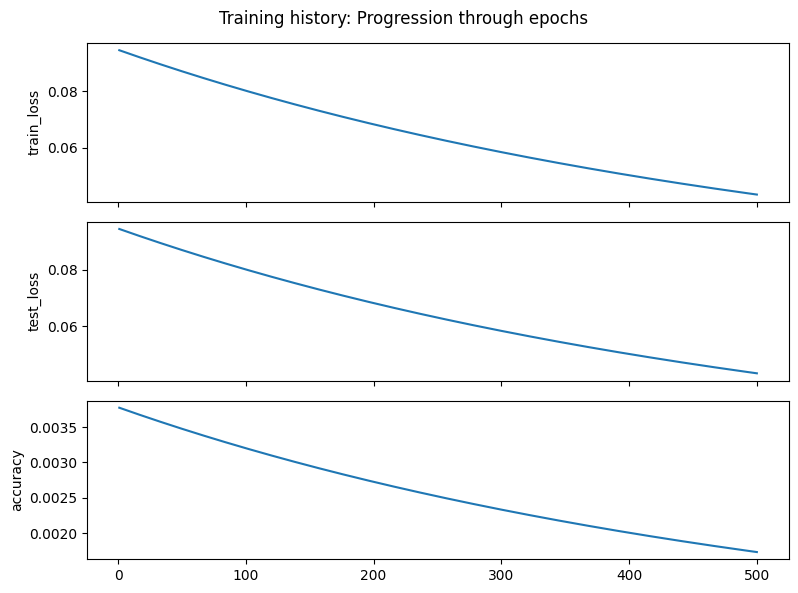

In [9]:
import matplotlib.pyplot as plt
history = {
    'train_loss': [],
    'test_loss': [],
    'accuracy': [],
}

epochs = 500
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
    # Save training progress to historical sequence
    history['train_loss'].append(float(train_loss))
    history['test_loss'].append(float(test_loss))
    history['accuracy'].append(float(test_accuracy))

print("Done training!")

# Create the figure and subplots
n_subplots = 3
epoch_axis_data = list(range(1, epochs+1))
fig, axs = plt.subplots(n_subplots, 1, sharex=True, figsize=(8, 6))
for idx, (label, history) in zip(range(n_subplots), history.items()):
    axs[idx].plot(epoch_axis_data, history)
    axs[idx].set_ylabel(label)

fig.suptitle('Training history: Progression through epochs')
plt.tight_layout()
plt.subplots_adjust(top=0.925)
plt.show()

## Saving the model

In [10]:
model_path = os.path.join(model_dir, "model.pth")
torch.save(model.state_dict(), model_path)
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading models and making predictions:

In [12]:
import random
model = NeuralNetwork(network_arch=network_arch).to(device)
model.load_state_dict(torch.load(model_path, weights_only=True))

model.eval()

vx_pos = int(np.where(labels_array == 'air_v_x')[0][0])
vx_speeds = []
h_outputs = []
h_actuals = []
random_vxs = np.sort(np.random.uniform(0, 1, size=20))  # sorting the random values helps in plotting later
random_vxs[0] = 1
with torch.no_grad():
    for r_vx in random_vxs:
        x, y = TrainingDataset.__getitem__(114)
        x[vx_pos] = r_vx
        vx_speeds.append(r_vx)
        x = x.to(device)
        pred = model(x)
        preds_untransformed = nn_output_transf(nn_output=pred, 
                                               data_means=TrainingDataset.data_means, 
                                               data_vars=TrainingDataset.data_vars, 
                                               operation='standardize',
                                               output_data_positions=TrainingDataset.output_data_positions,
                                               labels=TrainingDataset.labels)
        h_outputs.append(preds_untransformed.tolist())
        if r_vx == 1:
            print("MSE error: " + str(torch.nn.functional.mse_loss(pred, y)))
            print("data set Output")
            print(y)
            print("prediction input")
            print(x)
            print("prediction output")
            print(pred)
            print("prediction output transformed")

vx_speeds = [ 5 * x for x in vx_speeds]

MSE error: tensor(0.0254)
data set Output
tensor([0.1395, 0.4189, 0.2747, 0.2747, 0.3080, 0.0405, 0.0728, 0.0724, 0.0894,
        0.0884, 0.1885, 0.2008, 0.1966])
prediction input
tensor([0.1250, 1.0000, 0.0000, 0.0000, 0.2500, 0.4800, 0.5400, 0.4800, 0.5400,
        0.5160, 0.5200, 0.2500])
prediction output
tensor([ 0.0423,  0.3871, -0.0179,  0.0177,  0.3560,  0.0678, -0.0046, -0.0418,
         0.3480, -0.1097,  0.0442,  0.2307,  0.3302])
prediction output transformed


## Plotting 20 random predictions vs data

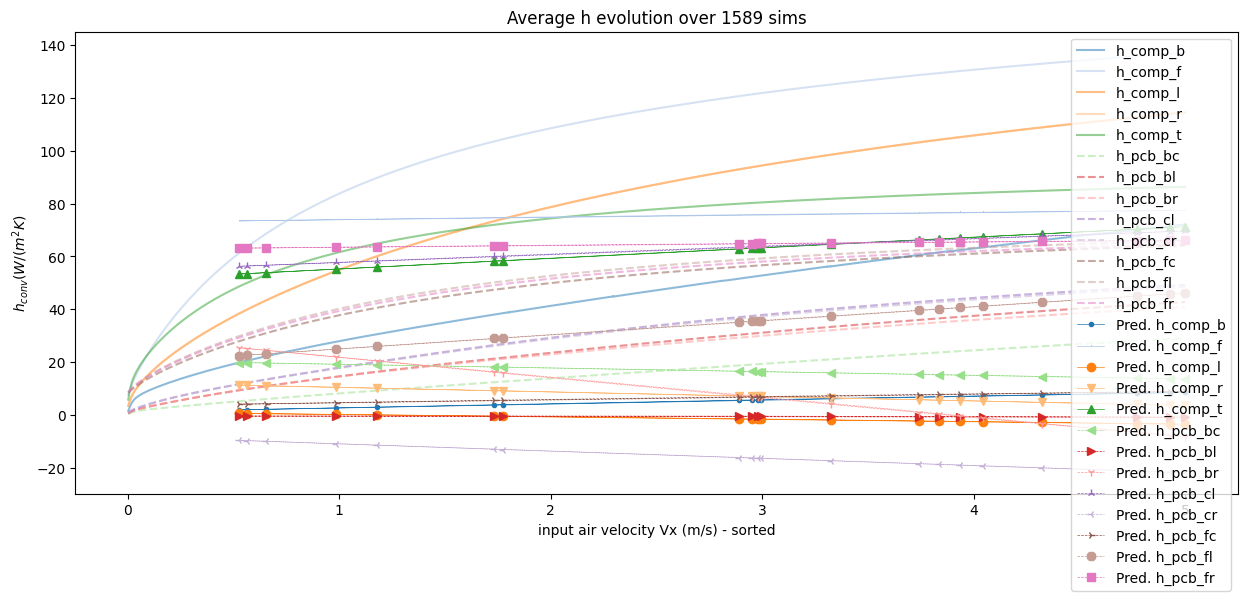

Original data for line 335:
['air_temp 25.0', 'air_v_x 1.0042691584696384', 'air_v_y 0.0', 'air_v_z 0.0', 'comp_temp 50.0', 'comp_x_pos -2.0', 'comp_x_size 4.0', 'comp_y_pos -2.0', 'comp_y_size 4.0', 'comp_z_pos 1.6', 'comp_z_size 2.0', 'h_comp_b 27.943838790322587', 'h_comp_f 83.90145322580645', 'h_comp_l 55.04120879032257', 'h_comp_r 55.037655725806445', 'h_comp_t 61.66737202216066', 'h_pcb_bc 8.116407368420635', 'h_pcb_bl 14.601736089385453', 'h_pcb_br 14.514256163872433', 'h_pcb_cl 17.933718995215', 'h_pcb_cr 17.72181889952118', 'h_pcb_fc 37.765616586921524', 'h_pcb_fl 40.229484729981294', 'h_pcb_fr 39.37729292364965', 'pcb_temp 50.0']
data for line 335 from dataset:
(tensor([0.1250, 0.3106, 0.0000, 0.0000, 0.2500, 0.4800, 0.5400, 0.4800, 0.5400,
        0.5160, 0.5200, 0.2500], grad_fn=<ToCopyBackward0>), tensor([0.2697, 0.6149, 0.4791, 0.4790, 0.4046, 0.0992, 0.1591, 0.1532, 0.1930,
        0.1901, 0.2859, 0.2987, 0.2927], grad_fn=<ToCopyBackward0>))
Predicted data for line 335:


In [13]:

import matplotlib as mpl
# We will sort the data based on the first column using np.sort
# sorted_h_data = np.sort(loaded_data, axis=0)
sorting_indexes = loaded_data[:, 1].argsort()
sorted_h_data = loaded_data[sorting_indexes, :]
orig_position_of_line_335 = np.where(sorting_indexes == 335)
h_outputs_cols = list(zip(*h_outputs))

# Step 2: Plot the 13 vectors (columns) as a line graph
plt.figure(figsize=(15, 6))
labels_list = list(labels_array)
hkeylist = []
markers = iter(['.',',','o','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_'])
color_list = iter(mpl.color_sequences['tab20'])
# Loop through the 13 columns and plot each one as a line
for idx, key in enumerate(labels_list):
    # print(key, sorted_h_data[335, idx])
    if key.startswith('h'):
        hkeylist.append(str(key))
        line_style = '--' if 'pcb' in key else '-'
        # mrkr = next(markers)
        plt.plot(sorted_h_data[:, labels_list.index("air_v_x")], 
                 sorted_h_data[:, idx], 
                 label='{}'.format(key), 
                 linestyle=line_style,
                 color=next(color_list),
                #  marker=mrkr, 
                 alpha=0.5)
color_list = iter(mpl.color_sequences['tab20'])
for idx, key in enumerate(hkeylist):
    plt.plot(vx_speeds, h_outputs_cols[idx], 
          label='Pred. '+ key,
          linestyle='--' if 'pcb' in key else '-',
          linewidth=0.5,
          color=next(color_list),
          marker=next(markers))

# Add labels and title
plt.xlabel('input air velocity Vx (m/s) - sorted')
plt.ylabel(r'$h_{conv} (W/(m^2 K)$')
plt.title('Average h evolution over {n} sims'.format(n=len(sorted_h_data)))


# Display the legend
plt.legend()

# Show the plot
plt.show()

print("Original data for line 335:")
print([str(a)+" "+str(float(b)) for a, b in zip(labels_array, sorted_h_data[336, :])])
print("data for line 335 from dataset:")
print(TrainingDataset.__getitem__(335))
print("Predicted data for line 335:")